In this notebook we want to compare the performance of neural network with special hidden state, which is transfered between noisy images constructed from the original image similarly as in the recurrent neural network. We compare this idea with simple neural network without such hidden state working on the same dataset.

In [53]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import List, Tuple
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn.functional import cross_entropy
from torch.optim import SGD
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Normalize
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


We specify some basic hyperparameters. An especially crucial hyperparameter is "repeat," representing the number of images generated from a single image to construct a sequence. For this notebook we specify repeat = 5.

In [54]:
batch_size_train = 60
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
repeat = 5
random_seed = 1
n_epochs = 100

We create a custom transformation where we modify the color of bright pixels (let's say those are pixels with positive value). The transformation involves assigning the color of the background pixel to the bright pixel with a probability of 0.9 for each individual pixel.

In [55]:
class Add_Noise(object):
  def __init__(self, boundary=0, p=0.1):
    self.boundary = boundary
    self.p = p

  def __call__(self, sample):
    image = sample

    for i, layer in enumerate(image):
      for j, pixel in enumerate(layer):
        if pixel > self.boundary:
          if np.random.uniform(0, 1) > self.p:
            image[i][j] = -0.4242

    return image

Within this notebook cell we download a subset of the MNIST dataset to accommodate computational constraints.

In [56]:
from torch.utils.data import Dataset, DataLoader

mnist_train = MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


sub = list(range(0, len(mnist_train), 10))
mnist_train = torch.utils.data.Subset(mnist_train, sub)

mnist_test = MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

sub = list(range(0, len(mnist_test), 10))
mnist_test = torch.utils.data.Subset(mnist_test, sub)

Than we create a dataset using the custom MNIST_With_RepeatAndNoise class. This class generates copies of the images to match the length of our specified image sequence. Noise is introduced to the images.

In [57]:
class MNIST_With_RepeatAndNoise(Dataset):
    def __init__(self, mnist_dataset, repeat_factor=5, noise_transform=None):
        self.mnist_dataset = mnist_dataset
        self.repeat_factor = repeat_factor
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.mnist_dataset) * self.repeat_factor

    def __getitem__(self, idx):
        idx //= self.repeat_factor
        x, y = self.mnist_dataset[idx]
        y = torch.tensor(y)

        x = x.repeat(self.repeat_factor, 1, 1)
        y = y.repeat(self.repeat_factor)

        for i in range(self.repeat_factor):
          x[i] = self.noise_transform(x[i])

        return x, y

train_dataset = MNIST_With_RepeatAndNoise(mnist_train, repeat_factor=repeat, noise_transform=Add_Noise())
test_dataset = MNIST_With_RepeatAndNoise(mnist_test, repeat_factor=repeat, noise_transform=Add_Noise())


In the cell below we construct the dataloaders and the processed data is saved for future use. We can omit this cell if the data is already saved and we have access to it...

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=6000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

for i in range(len(train_loader)):
  x, y = next(iter(train_loader))
  torch.save(x, "train_data_0.1_rep5.pt")
  torch.save(y, "train_targets_0.1_rep5.pt")

for i in range(len(test_loader)):
  x, y = next(iter(test_loader))
  torch.save(x, "test_data_0.1_rep5.pt")
  torch.save(y, "test_targets_0.1_rep5.pt")

...in this case we can import the files in the cell below.

In [13]:
from google.colab import files
uploaded = files.upload()

Saving test_data_0.1_rep5.pt to test_data_0.1_rep5.pt


As the data is saved we can now load the data and use the CustomDataset class to get the desired datasets and dataloaders.

In [58]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data_path, targets_path):
        self.data = torch.load(data_path)
        self.targets = torch.load(targets_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        return x, y

train_data_path = "train_data_0.1_rep5.pt"
train_targets_path = "train_targets_0.1_rep5.pt"
test_data_path = "test_data_0.1_rep5.pt"
test_targets_path = "test_targets_0.1_rep5.pt"

train_dataset = CustomDataset(train_data_path, train_targets_path)
test_dataset = CustomDataset(test_data_path, test_targets_path)

train_loader_new = DataLoader(train_dataset, batch_size=60, shuffle=True)
test_loader_new = DataLoader(test_dataset, batch_size=10, shuffle=False)

Now we can visualize our data and convince ourselves that the noise is added correctly.

<Figure size 640x480 with 0 Axes>

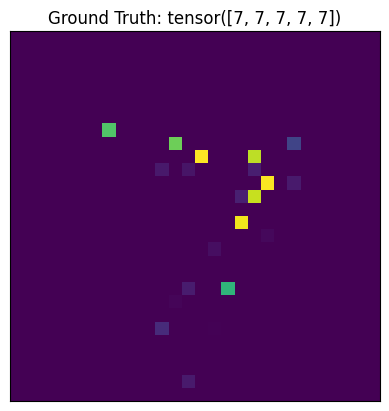

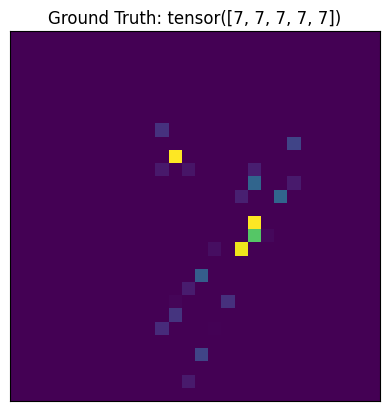

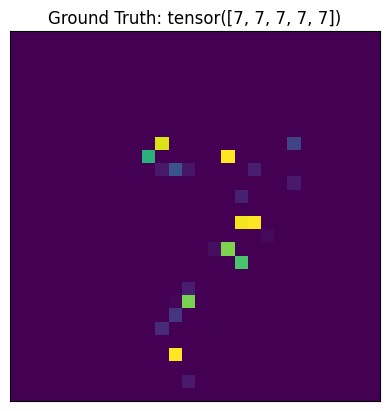

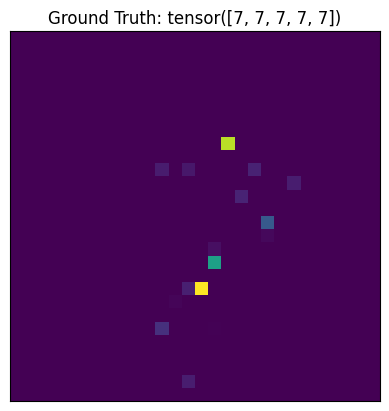

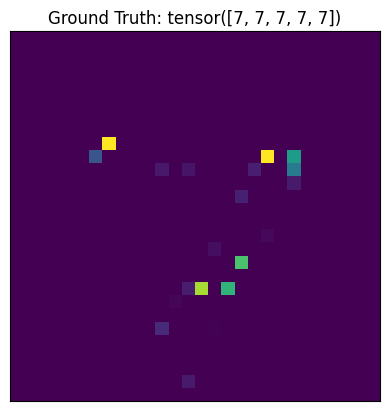

In [59]:
examples = enumerate(test_loader_new)
batch_idx, (example_data, example_targets) = next(examples)

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(repeat):
  fig = plt.figure()
  plt.tight_layout()
  plt.imshow(example_data[0, i, :, :], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[0]))
  plt.xticks([])
  plt.yticks([])

We construct the architecture for our neural network without hidden state:

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [61]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_new.dataset) for i in range(n_epochs + 1)]

We specify the train and test functions for the basic network:

In [62]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader_new):
    data, target = data.to(device), target.to(device)
    for r in range(repeat):
      optimizer.zero_grad()
      output = network(data[:, r, :, :].unsqueeze(1))
      loss = F.nll_loss(output, target[:, r])
      loss.backward()
      optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader_new.dataset),
        100. * batch_idx / len(train_loader_new), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*60) + ((epoch-1)*len(train_loader_new.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader_new:
      data, target = data.to(device), target.to(device)
      for r in range(repeat):
        output = network(data[:, r, :, :].unsqueeze(1))
        test_loss += F.nll_loss(output, target[:, r], size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target[:, 0].unsqueeze(1).data.view_as(pred)).sum()
  test_loss /= len(test_loader_new.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader_new.dataset),
    100. * correct / len(test_loader_new.dataset)))

Finally we can train our basic network:

In [63]:
for epoch in range(1, n_epochs + 1): #n_epochs=100
  train(epoch)
  test()

<ipython-input-60-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.324660
Train Epoch: 1 [600/6000 (10%)]	Loss: 2.278901
Train Epoch: 1 [1200/6000 (20%)]	Loss: 2.293642
Train Epoch: 1 [1800/6000 (30%)]	Loss: 2.326950
Train Epoch: 1 [2400/6000 (40%)]	Loss: 2.255645
Train Epoch: 1 [3000/6000 (50%)]	Loss: 2.311625
Train Epoch: 1 [3600/6000 (60%)]	Loss: 2.278098
Train Epoch: 1 [4200/6000 (70%)]	Loss: 2.287625
Train Epoch: 1 [4800/6000 (80%)]	Loss: 2.265040
Train Epoch: 1 [5400/6000 (90%)]	Loss: 2.276327


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 11.1952, Accuracy: 250/1000 (25%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 2.238049
Train Epoch: 2 [600/6000 (10%)]	Loss: 2.241622
Train Epoch: 2 [1200/6000 (20%)]	Loss: 2.255355
Train Epoch: 2 [1800/6000 (30%)]	Loss: 2.244993
Train Epoch: 2 [2400/6000 (40%)]	Loss: 2.163761
Train Epoch: 2 [3000/6000 (50%)]	Loss: 2.087819
Train Epoch: 2 [3600/6000 (60%)]	Loss: 2.135059
Train Epoch: 2 [4200/6000 (70%)]	Loss: 2.011917
Train Epoch: 2 [4800/6000 (80%)]	Loss: 2.004514
Train Epoch: 2 [5400/6000 (90%)]	Loss: 1.982890

Test set: Avg. loss: 8.7583, Accuracy: 497/1000 (50%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 1.978820
Train Epoch: 3 [600/6000 (10%)]	Loss: 1.948864
Train Epoch: 3 [1200/6000 (20%)]	Loss: 1.778458
Train Epoch: 3 [1800/6000 (30%)]	Loss: 1.551451
Train Epoch: 3 [2400/6000 (40%)]	Loss: 1.690750
Train Epoch: 3 [3000/6000 (50%)]	Loss: 1.769656
Train Epoch: 3 [3600/6000 (60%)]	Loss: 1.676157
Train Epoch: 3 [4200/6000 (70%)]	Loss: 1.797528
Train Epoch: 3 [4800/6000 (80%)]	

We construct the architecture for our neural network with hidden state:


In [64]:
class Net_hidden(nn.Module):
    def __init__(self):
        super(Net_hidden, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(100, 10)
        self.batch = 60
        self.hidden = torch.zeros([self.batch, 50]).to(device)

    def zero_hidden(self):
        self.hidden = torch.zeros([self.batch, 50]).to(device)

    def update_hidden(self, x):
        self.hidden = x.to(device)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        new_hidden = F.dropout(x, training=self.training)
        x = torch.cat((new_hidden, self.hidden), 1)

        x = self.fc2(x)
        return F.log_softmax(x), new_hidden

We specify the train and test functions for the network with hidden state:

In [65]:
def train_hidden(epoch):
  network.batch = 60
  network.zero_hidden()
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader_new):
    data, target = data.to(device), target.to(device)
    network.zero_hidden()
    for r in range(repeat):
      optimizer.zero_grad()
      output, hidden = network(data[:, r, :, :].unsqueeze(1))
      loss = F.nll_loss(output, target[:, r])
      loss.backward()
      optimizer.step()
      hidden = hidden.detach()
      network.update_hidden(hidden)
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader_new.dataset),
        100. * batch_idx / len(train_loader_new), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*60) + ((epoch-1)*len(train_loader_new.dataset)))

def test_hidden():
  network.batch = 10
  network.zero_hidden()
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader_new:
      data, target = data.to(device), target.to(device)
      network.zero_hidden()
      for r in range(repeat):
        output, hidden = network(data[:, r, :, :].unsqueeze(1))
        test_loss += F.nll_loss(output, target[:, r], size_average=False).item()
        network.update_hidden(hidden)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target[:, 0].unsqueeze(1).data.view_as(pred)).sum()
  test_loss /= len(test_loader_new.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader_new.dataset),
    100. * correct / len(test_loader_new.dataset)))

And we can train our network with hidden state:

In [66]:
network = Net_hidden().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_new.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1): #n_epochs=100
  train_hidden(epoch)
  test_hidden()

<ipython-input-64-8dfb2fdbc020>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x), new_hidden


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.303540
Train Epoch: 1 [600/6000 (10%)]	Loss: 2.309931
Train Epoch: 1 [1200/6000 (20%)]	Loss: 2.315399
Train Epoch: 1 [1800/6000 (30%)]	Loss: 2.302419
Train Epoch: 1 [2400/6000 (40%)]	Loss: 2.292197
Train Epoch: 1 [3000/6000 (50%)]	Loss: 2.296986
Train Epoch: 1 [3600/6000 (60%)]	Loss: 2.278665
Train Epoch: 1 [4200/6000 (70%)]	Loss: 2.287346
Train Epoch: 1 [4800/6000 (80%)]	Loss: 2.262486
Train Epoch: 1 [5400/6000 (90%)]	Loss: 2.296716

Test set: Avg. loss: 11.3008, Accuracy: 242/1000 (24%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 2.262580
Train Epoch: 2 [600/6000 (10%)]	Loss: 2.249524
Train Epoch: 2 [1200/6000 (20%)]	Loss: 2.287060
Train Epoch: 2 [1800/6000 (30%)]	Loss: 2.239778
Train Epoch: 2 [2400/6000 (40%)]	Loss: 2.191056
Train Epoch: 2 [3000/6000 (50%)]	Loss: 2.180016
Train Epoch: 2 [3600/6000 (60%)]	Loss: 2.164342
Train Epoch: 2 [4200/6000 (70%)]	Loss: 2.165930
Train Epoch: 2 [4800/6000 (80%)]	Loss: 2.154027
Train Epoch: 2 [5400/6000 (90%)]	Loss: 2.

We can see that the accuracy has increased from about 80% to 86%.
